# **Twitter Sentiment Analysis**
*   The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.
*   Formally, given a training sample of **tweets** and **labels**, where ***label '1'*** denotes the tweet is racist/sexist and ***label '0'*** denotes the tweet is not racist/sexist.

# **Installing & Importing Necessary Libraries**

In [ ]:
!pip install transformers
!pip install nlpaug

In [ ]:
import numpy as np
import pandas as pd
import warnings as we
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
import nlpaug.augmenter.word.context_word_embs as aug

from tqdm.auto import tqdm

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import word_tokenize

from wordcloud import WordCloud
from textblob import TextBlob, Word

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, SimpleRNN, LSTM, GRU, Bidirectional 

we.filterwarnings('ignore')

# **EDA**

## **Exploring DataFrame**

In [3]:
df = pd.read_csv('/content/train.csv')
df

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB




*   The dataset contains three columns - "id", "label", "tweet"
*   Column "id" is not useful for classification.
*   Column "tweet" contains the tweets and column "label" contains their category.
*   There is no null values.

In [5]:
df.drop('id', axis = 1, inplace = True) # Droping the column 'ID'

**Visualization**

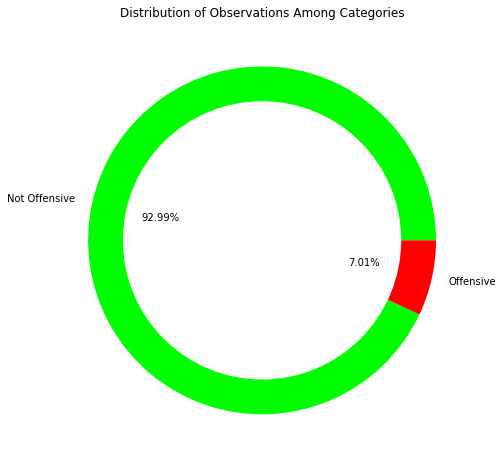

In [6]:
plt.figure(figsize=(8,8))
plt.title('Distribution of Observations Among Categories')
plt.pie(
    df["label"].value_counts(),
    autopct = "%.2f%%",
    labels = ["Not Offensive", "Offensive"],
    colors = ["#00ff00", "#ff0000"]
)

circle = plt.Circle((0,0), 0.80,fc='white')
fig = plt.gcf()
fig.gca().add_artist(circle)
plt.show()

In [7]:
# Joining the Values for Visualization
positive_review = ' '.join(df[df["label"] == 0]["tweet"])
negative_review = ' '.join(df[df["label"] == 1]["tweet"])

**Word CLoud of Positive Reviews**

Before Processing

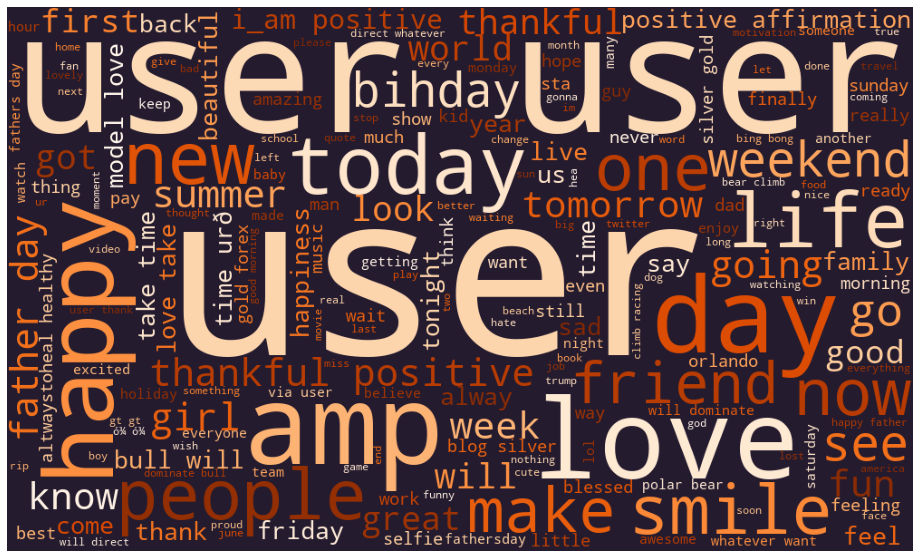

In [8]:
wc = WordCloud(width = 1000, height = 600, background_color = "#241b2f", min_font_size = 12, colormap = 'Oranges')

wc.generate(positive_review)

plt.figure(figsize=(20,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

**Word Cloud of Negative Reviews**

Before Processing

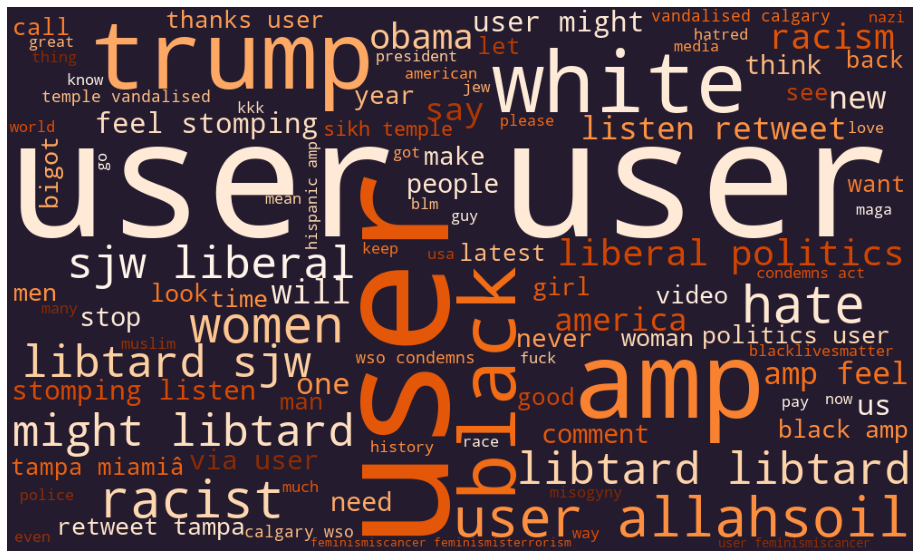

In [9]:
wc = WordCloud(width = 1000, height = 600, background_color = "#241b2f", min_font_size = 12, colormap = 'Oranges')

wc.generate(negative_review)

plt.figure(figsize=(20,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

# **Text Classification**


> Without Data Cleaning


> Without Data Augmentation (Balancing)




## **Machine Learning**

In [10]:
# Splitting the Data using train test split
X1 = df['tweet'] # Feature
y1 = df['label'] # Target

# train test split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X1, y1, test_size = 0.3, random_state = 6)

In [11]:
print('X Data Count:', X1.shape)
print('X_train Count:', X_train_1.shape)
print('X_test Count:', X_test_1.shape)

X Data Count: (31962,)
X_train Count: (22373,)
X_test Count: (9589,)


### **Transforming the Data using TF-IDF**

Using TfidVectorizer to transform the text data to feature vector which will be used as input for Models

In [12]:
fe = TfidfVectorizer(min_df = 1, stop_words = 'english', lowercase = True)

X_train_f = fe.fit_transform(X_train_1)
X_test_f = fe.transform(X_test_1)

### **Random Forest Classifier**

In [13]:
rfc = RandomForestClassifier()

rfc.fit(X_train_f, y_train_1) # Training the Model
rfc_pred = rfc.predict(X_test_f) # Prediction

In [14]:
print('******************************************************')
print(classification_report(y_test_1, rfc_pred))
print('******************************************************')
print(confusion_matrix(y_test_1, rfc_pred))
print('**************')

******************************************************
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      8918
           1       0.95      0.44      0.60       671

    accuracy                           0.96      9589
   macro avg       0.95      0.72      0.79      9589
weighted avg       0.96      0.96      0.95      9589

******************************************************
[[8901   17]
 [ 377  294]]
**************


## **Artificial Neural Network**

In [15]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_1)

In [16]:
vocab_len = len(tokenizer.index_word)
vocab_len

36495

In [17]:
# text to sequence
train1_sequence = tokenizer.texts_to_sequences(X_train_1)

In [18]:
doc_len = []
for doc in train1_sequence:
  doc_len.append(len(doc))

max(doc_len) # Maximum Size of a Sentence

42

In [19]:
# Checking 99% Values Length
np.quantile(doc_len, 0.99)

26.0

In [20]:
max_length = 26  # taking Max Length as 99% 

In [21]:
# padding
train1_matrix = sequence.pad_sequences(train1_sequence, max_length)
train1_matrix

array([[    0,     1,    46, ...,  2806,  8151,    38],
       [    0,     0,     0, ...,    79,    70,    77],
       [    0,     0,     1, ...,    10,  8152, 12752],
       ...,
       [    0,     0,     0, ...,  2632,     9,     1],
       [    0,     0,     0, ...,  3032,  1480, 10663],
       [    0,     0,     0, ...,  2448,  2680,  1398]], dtype=int32)

In [22]:
# All the procedure on Testing Data

test1_sequence = tokenizer.texts_to_sequences(X_test_1)
test1_matrix = sequence.pad_sequences(test1_sequence, max_length)
test1_matrix

array([[    0,     0,     0, ...,    18,     2,   384],
       [    0,     0,     0, ...,   664,   524,   413],
       [    0,     0,     0, ...,    77,   394, 23309],
       ...,
       [    0,     0,     0, ...,   128,   902,   190],
       [    0,     0,     0, ...,     0,     0,   230],
       [    0,     0,     0, ...,    95,    21,   323]], dtype=int32)

### **Bidirectional LSTM and Multi-layer**

In [23]:
model1 = Sequential()
model1.add(Embedding( input_dim = vocab_len + 1,
                      output_dim = 64,
                      input_length = max_length,
                      mask_zero = True))
model1.add(Bidirectional(LSTM(64, return_sequences = True)))
model1.add(Bidirectional(LSTM(64)))
model1.add(Dense(64, activation = "relu"))
model1.add(Dense(32, activation = "relu"))
model1.add(Dense(16, activation = "relu"))
model1.add(Dense(1, activation = "sigmoid"))

model1.compile(optimizer = "adam", loss = "binary_crossentropy")

In [25]:
model1.fit(train1_matrix, y_train_1, epochs = 5, batch_size = 64)

Epoch 1/5
350/350 [==============================] - 55s 123ms/step - loss: 0.1779
Epoch 2/5
350/350 [==============================] - 44s 124ms/step - loss: 0.0505
Epoch 3/5
350/350 [==============================] - 43s 123ms/step - loss: 0.0177
Epoch 4/5
350/350 [==============================] - 44s 126ms/step - loss: 0.0070
Epoch 5/5
350/350 [==============================] - 43s 122ms/step - loss: 0.0046


In [26]:
mod1_pred = model1.predict(test1_matrix)
mod1_pred = np.where(mod1_pred >= 0.5, 1, 0)

print('******************************************************')
print(classification_report(y_test_1, mod1_pred))
print('******************************************************')
print(confusion_matrix(y_test_1, mod1_pred))
print('**************')

******************************************************
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      8918
           1       0.78      0.60      0.68       671

    accuracy                           0.96      9589
   macro avg       0.88      0.80      0.83      9589
weighted avg       0.96      0.96      0.96      9589

******************************************************
[[8807  111]
 [ 266  405]]
**************


# **Text Classification**


> With Data Cleaning


> With Data Augmentation (Balancing)




## **Data Cleaning**

In [27]:
# Removes pattern in the input text
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
    return input_txt

In [28]:
df['clean_tweet'] = np.vectorize(remove_pattern)(df['tweet'], "@[\w]*")  # Remove Twitter Handles (@user)
df['clean_tweet'] = df['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))  # converting to lower case

In [29]:
# Removing the Stopwords
stop_words = stopwords.words('english')
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

In [30]:
df['clean_tweet'] = df['clean_tweet'].str.replace('[^\w\s\ð\]', '') # Removing Unwanted Data

In [31]:
# Top Common Words used
common_top20 = pd.Series(' '.join(df['clean_tweet']).split()).value_counts()[:20]
common = list(common_top20.index)

# Removing common Words
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in common))

In [32]:
# Frequency of common words in all the tweets
rare_top20 = pd.Series(" ".join(df['clean_tweet']).split()).value_counts()[-20:]
rare_top20

# Remove these top 20 common words
rare = list(rare_top20.index)
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in rare))

In [33]:
# Tokenization
df['clean_tweet'].apply(lambda x: TextBlob(x).words)

# Stemming and Lemmatizing
lemma = WordNetLemmatizer()
df['clean_tweet'].apply(lambda x: " ".join([lemma.lemmatize(word) for word in x.split()]))

# Joining Tokens 
df['clean_tweet'].apply(lambda x: " ".join(Word(word) for word in x.split()))

0        father dysfunctional selfish drags kids dysfun...
1        thanks lyft credit cant use cause offer wheelc...
2                                                  majesty
3                          model take urð ðððð ððð
4                            factsguide society motivation
                               ...                        
31957                    ate isz youuuðððððððððâï
31958    see nina turner airwaves trying wrap mantle ge...
31959      listening sad songs monday morning otw work sad
31960      sikh temple vandalised calgary wso condemns act
31961                                         thank follow
Name: clean_tweet, Length: 31962, dtype: object

In [34]:
df

,label,tweet,clean_tweet
0,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drags kids dysfun...
1,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit cant use cause offer wheelc...
2,0,bihday your majesty,majesty
3,0,#model i love u take with u all the time in ...,model take urð ðððð ððð
4,0,factsguide: society now #motivation,factsguide society motivation
...,...,...,...
31957,0,ate @user isz that youuu?ðððððð...,ate isz youuuðððððððððâï
31958,0,to see nina turner on the airwaves trying to...,see nina turner airwaves trying wrap mantle ge...
31959,0,listening to sad songs on a monday morning otw...,listening sad songs monday morning otw work sad
31960,1,"@user #sikh #temple vandalised in in #calgary,...",sikh temple vandalised calgary wso condemns act




> Droping tweet column as it is of no use



In [35]:
df.drop(labels = 'tweet', axis = 1, inplace = True)

In [36]:
# Joining the Values for Visualization
positive_review = ' '.join(df[df["label"] == 0]["clean_tweet"])
negative_review = ' '.join(df[df["label"] == 1]["clean_tweet"])

**Word CLoud of Positive Reviews**

After Processing

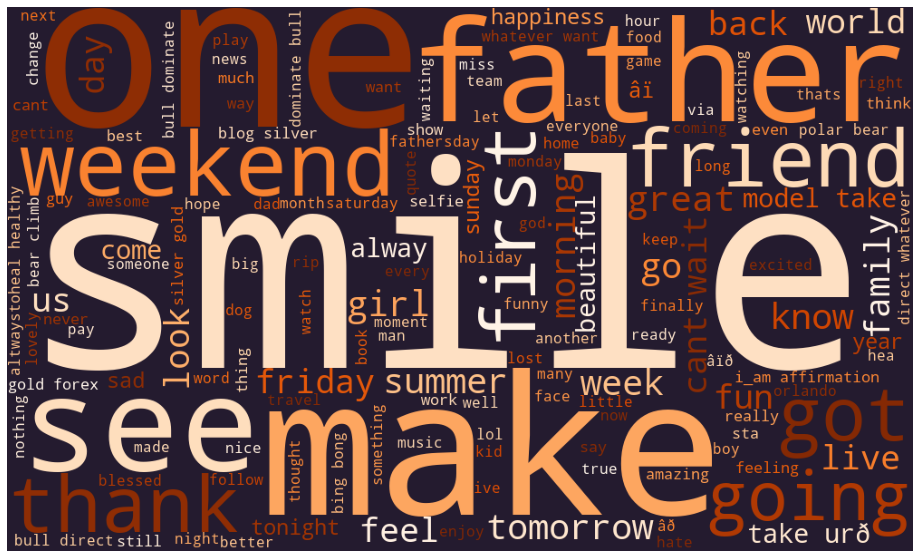

In [37]:
wc = WordCloud(width = 1000, height = 600, background_color = "#241b2f", min_font_size = 12, colormap = 'Oranges')

wc.generate(positive_review)

plt.figure(figsize=(20,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

**Word CLoud of Negative Reviews**

After Processing

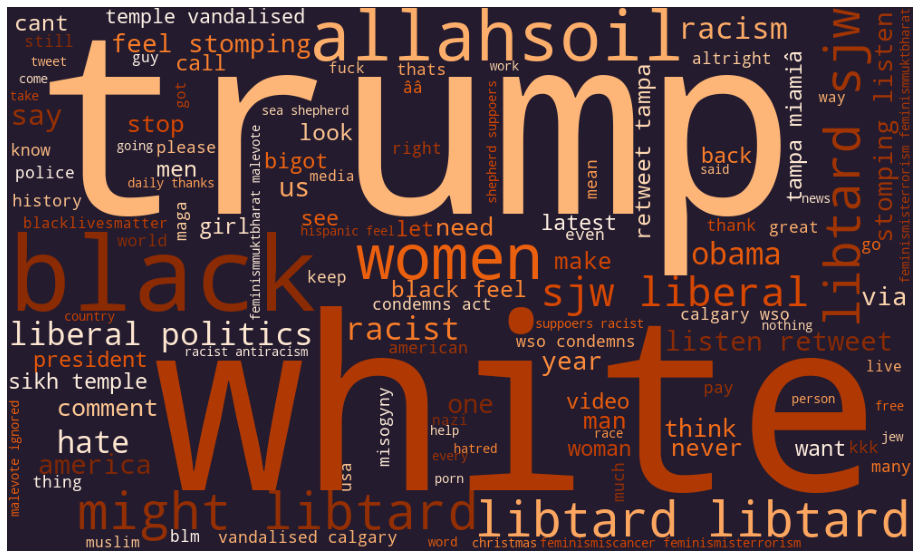

In [38]:
wc = WordCloud(width = 1000, height = 600, background_color = "#241b2f", min_font_size = 12, colormap = 'Oranges')

wc.generate(negative_review)

plt.figure(figsize=(20,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

## **Data Augmentation**


> Example of Data Augementation



In [39]:
sample_text = df['clean_tweet'].iloc[1905]
sample_text

'lying cheating career criminalhope prisonu forget fbi'

In [40]:
augmenter = aug.ContextualWordEmbsAug(model_path = 'bert-base-uncased', action = "insert")

In [41]:
for i in range(5):
    print(augmenter.augment(sample_text))

lying cheating fraud career at criminalhope prisonu forget about fbi
private lying criminal cheating career police criminalhope prisonu forget fbi
lying or cheating career of criminalhope prisonu no forget fbi
lying cheating for career from criminalhope prisonu forget it fbi
innocent lying cheating career criminal criminalhope with prisonu forget fbi


As the example shows, using Data Augmentation we can produce different sentences for balancing the Data

In [42]:
def augmentMyData(df, augmenter, repetitions = 1, samples = 500):
    augmented_texts = []

    # select only the minority class samples
    negate = df[df['label'] == 1].reset_index(drop = True) # removes unecessary index column
    for i in tqdm(np.random.randint(0, len(negate), samples)):
      
        # generating 'n_samples' augmented texts
        for _ in range(repetitions):
            augmented_text = augmenter.augment(negate['clean_tweet'].iloc[i])
            augmented_texts.append(augmented_text)
    
    data = {'label': 1, 'clean_tweet': augmented_texts}
    aug_df = pd.DataFrame(data)
    df = shuffle(df.append(aug_df).reset_index(drop = True))
    return df

Above Function will return extra samples. We can specify how many samples do we need.


> aug_df = augmentMyData(df, augmenter, samples = 10000)



*   This Code runs and gives desired samples, the only challenge is that it takes long time to run
*   For this purpose I had already ran the code and got the output, that is I would use that data set further.
*   I am attaching screenshot for the same.

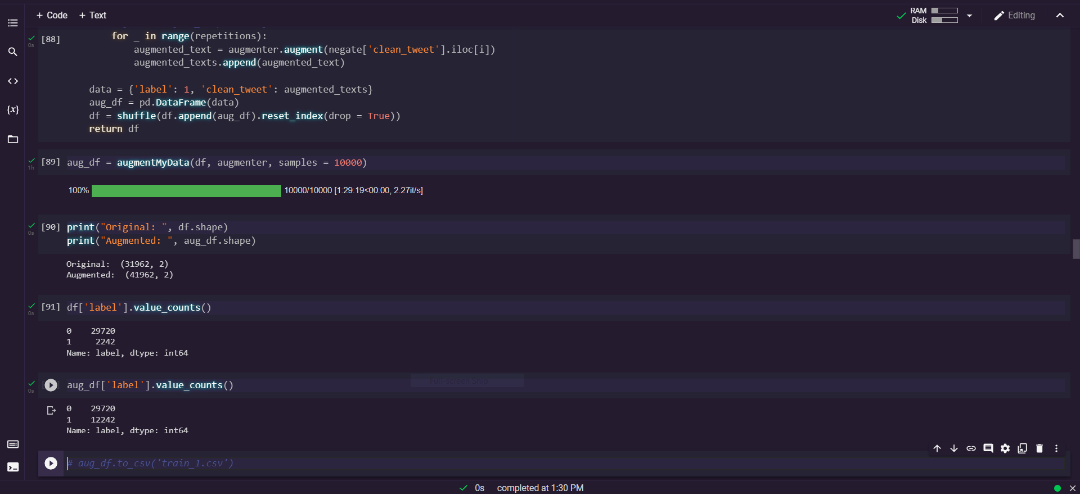

In [43]:
df_new = pd.read_csv('/content/new_train.csv')
df_new

,Unnamed: 0,label,clean_tweet
0,0,1,chick gets sexually fucked over nude superhero
1,1,0,think little everyday mycuteboyfriend almostfo...
2,2,0,ðampð go 2the victims ampfamilies horrible a...
3,3,0,spa friday
4,4,0,small segment vase decorativewoodturningflower...
...,...,...,...
41957,41957,0,free copy suburbal feral book ends wednesay en...
41958,41958,1,great speech war veteran iraq war profit milit...
41959,41959,0,amsterdam dubai 6 hours sleep us goodnight
41960,41960,0,team set conduct developer product offering te...


In [44]:
df_new.isnull().sum() 

Unnamed: 0      0
label           0
clean_tweet    43
dtype: int64

In [45]:
df_new.dropna(inplace = True) # Droping Null Values

In [46]:
df_new.isnull().sum()

Unnamed: 0     0
label          0
clean_tweet    0
dtype: int64

In [47]:
# Removing Unnecessary column
df_new.drop('Unnamed: 0', axis = 1, inplace = True)

## ***Visualization***

In [48]:
# Comparing the two Data Frames
print("Original: ", df.shape)
print("Augmented: ", df_new.shape)

Original:  (31962, 2)
Augmented:  (41919, 2)


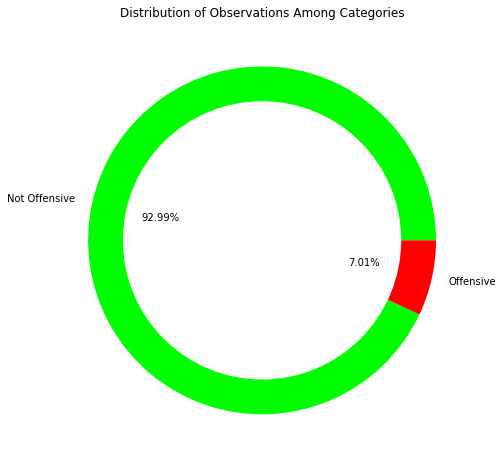

In [49]:
# Old Data
plt.figure(figsize=(8,8))
plt.title('Distribution of Observations Among Categories')
plt.pie(
    df["label"].value_counts(),
    autopct = "%.2f%%",
    labels = ["Not Offensive", "Offensive"],
    colors = ["#00ff00", "#ff0000"]
)

circle = plt.Circle((0,0), 0.80,fc='white')
fig = plt.gcf()
fig.gca().add_artist(circle)
plt.show()

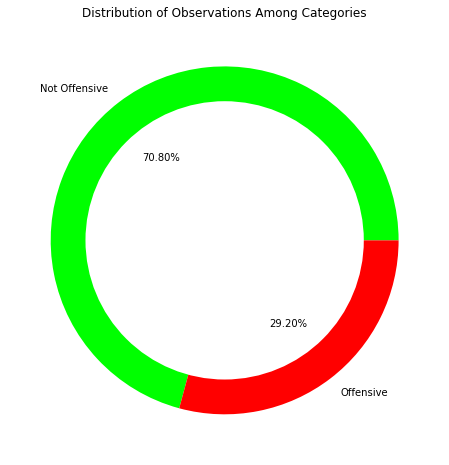

In [50]:
# New Data
plt.figure(figsize=(8,8))
plt.title('Distribution of Observations Among Categories')
plt.pie(
    df_new["label"].value_counts(),
    autopct = "%.2f%%",
    labels = ["Not Offensive", "Offensive"],
    colors = ["#00ff00", "#ff0000"]
)

circle = plt.Circle((0,0), 0.80,fc='white')
fig = plt.gcf()
fig.gca().add_artist(circle)
plt.show()

In [51]:
print('Old Data: ')
print(df['label'].value_counts())
print()
print('New Data: ')
print(df_new['label'].value_counts())

Old Data: 
0    29720
1     2242
Name: label, dtype: int64

New Data: 
0    29677
1    12242
Name: label, dtype: int64


## **Machine Learning**

In [52]:
# Splitting the Data using train test split
X2 = df_new['clean_tweet'] # Feature
y2 = df_new['label'] # Target

# train test split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X2, y2, test_size = 0.3, random_state = 6)

In [53]:
print('X Data Count:', X2.shape)
print('X_train Count:', X_train_2.shape)
print('X_test Count:', X_test_2.shape)

X Data Count: (41919,)
X_train Count: (29343,)
X_test Count: (12576,)


### **Transforming the Data using TF-IDF**

Using TfidVectorizer to transform the text data to feature vector which will be used as input for Models

In [54]:
fe = TfidfVectorizer(min_df = 1, stop_words = 'english', lowercase = True)

X_train_f2 = fe.fit_transform(X_train_2)
X_test_f2 = fe.transform(X_test_2)

### **Random Forest Classifier**

In [55]:
rfc2 = RandomForestClassifier()

rfc2.fit(X_train_f2, y_train_2) # Training the Model
rfc2_pred = rfc2.predict(X_test_f2) # Prediction

In [56]:
print('******************************************************')
print(classification_report(y_test_2, rfc2_pred))
print('******************************************************')
print(confusion_matrix(y_test_2, rfc2_pred))
print('**************')

******************************************************
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      8912
           1       0.95      0.98      0.97      3664

    accuracy                           0.98     12576
   macro avg       0.97      0.98      0.98     12576
weighted avg       0.98      0.98      0.98     12576

******************************************************
[[8740  172]
 [  72 3592]]
**************


## **Artificial Neural Network**

In [57]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_2)

In [58]:
vocab_len = len(tokenizer.index_word)
vocab_len

37377

In [59]:
# text to sequence
train2_sequence = tokenizer.texts_to_sequences(X_train_2)

In [60]:
doc_len = []
for doc in train2_sequence:
  doc_len.append(len(doc))

max(doc_len) # Maximum Size of a Sentence

30

In [61]:
# Checking 99% Values Length
np.quantile(doc_len, 0.99)

19.0

In [62]:
max_length = 19  # taking Max Length as 99% 

In [63]:
# padding
train2_matrix = sequence.pad_sequences(train2_sequence, max_length)
train2_matrix

array([[    0,     0,     0, ...,   325,  1239,  3391],
       [    0,     0,     0, ..., 15226, 10865,   295],
       [    0,     0,     0, ...,   289,   290,  5420],
       ...,
       [    0,     0,     0, ...,   404, 11977, 37377],
       [    0,     0,     0, ...,   698,    84,   723],
       [    0,     0,     0, ...,  8907,  1290,  1287]], dtype=int32)

In [64]:
# All the procedure on Testing Data

test2_sequence = tokenizer.texts_to_sequences(X_test_2)
test2_matrix = sequence.pad_sequences(test2_sequence, max_length)
test2_matrix

array([[    0,     0,     0, ...,  3835,   480,     4],
       [    0,     0,     0, ...,   289,  2012,   602],
       [    0,     0,     0, ...,   843,   936,   535],
       ...,
       [    0,     0,     0, ..., 20374,   492,   264],
       [    0,     0,     0, ...,   149,    78,    18],
       [    0,     0,     0, ...,   164,  1092,  2379]], dtype=int32)

### **Bidirectional LSTM and Multi-layer**

In [65]:
model2 = Sequential()
model2.add(Embedding( input_dim = vocab_len + 1,
                      output_dim = 64,
                      input_length = max_length,
                      mask_zero = True))
model2.add(Bidirectional(LSTM(64, return_sequences = True)))
model2.add(Bidirectional(LSTM(64)))
model2.add(Dense(64, activation = "relu"))
model2.add(Dense(32, activation = "relu"))
model2.add(Dense(16, activation = "relu"))
model2.add(Dense(1, activation = "sigmoid"))

model2.compile(optimizer = "adam", loss = "binary_crossentropy")

In [66]:
model2.fit(train2_matrix, y_train_2, epochs = 5, batch_size = 64)

Epoch 1/5
459/459 [==============================] - 61s 98ms/step - loss: 0.1638
Epoch 2/5
459/459 [==============================] - 56s 122ms/step - loss: 0.0270
Epoch 3/5
459/459 [==============================] - 45s 99ms/step - loss: 0.0096
Epoch 4/5
459/459 [==============================] - 45s 99ms/step - loss: 0.0045
Epoch 5/5
459/459 [==============================] - 46s 100ms/step - loss: 0.0035


In [67]:
mod2_pred = model2.predict(test2_matrix)
mod2_pred = np.where(mod2_pred >= 0.5, 1, 0)

print('******************************************************')
print(classification_report(y_test_2, mod2_pred))
print('******************************************************')
print(confusion_matrix(y_test_2, mod2_pred))
print('**************')

******************************************************
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      8912
           1       0.95      0.98      0.96      3664

    accuracy                           0.98     12576
   macro avg       0.97      0.98      0.98     12576
weighted avg       0.98      0.98      0.98     12576

******************************************************
[[8717  195]
 [  66 3598]]
**************


### **Test Data**

In [68]:
test = pd.read_csv('/content/test.csv')
test

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."
...,...,...
17192,49155,thought factory: left-right polarisation! #tru...
17193,49156,feeling like a mermaid ð #hairflip #neverre...
17194,49157,#hillary #campaigned today in #ohio((omg)) &am...
17195,49158,"happy, at work conference: right mindset leads..."


In [69]:
# Removing ID Column
test.drop('id', axis = 1, inplace = True)

In [70]:
test.info() # No Null Values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   17197 non-null  object
dtypes: object(1)
memory usage: 134.5+ KB


### **Data Cleaning**

In [71]:
test['clean_tweet'] = np.vectorize(remove_pattern)(test['tweet'], "@[\w]*")  # Remove Twitter Handles (@user)
test['clean_tweet'] = test['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))  # converting to lower case

In [72]:
# Removing the Stopwords
stop_words = stopwords.words('english')
test['clean_tweet'] = test['clean_tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

In [73]:
test['clean_tweet'] = test['clean_tweet'].str.replace('[^\w\s\ð\]', '') # Removing Unwanted Data

In [74]:
# Top Common Words used
common_top20 = pd.Series(' '.join(test['clean_tweet']).split()).value_counts()[:20]
common = list(common_top20.index)

# Removing common Words
test['clean_tweet'] = test['clean_tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in common))

In [75]:
# Frequency of common words in all the tweets
rare_top20 = pd.Series(" ".join(test['clean_tweet']).split()).value_counts()[-20:]
rare_top20

# Remove these top 20 common words
rare = list(rare_top20.index)
test['clean_tweet'] = test['clean_tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in rare))

In [76]:
# Tokenization
test['clean_tweet'].apply(lambda x: TextBlob(x).words)

# Stemming and Lemmatizing
lemma = WordNetLemmatizer()
test['clean_tweet'].apply(lambda x: " ".join([lemma.lemmatize(word) for word in x.split()]))

# Joining Tokens 
test['clean_tweet'].apply(lambda x: " ".join(Word(word) for word in x.split()))

0        studiolife aislife requires passion dedication...
1        white supremacists want everyone see birdsâ mo...
2        safe ways heal acne altwaystoheal healthy healing
3        hp cursed child book reservations already yes ...
4        3rd amazing hilarious nephew eli ahmir uncle d...
                               ...                        
17192    thought factory leftright polarisation trump u...
17193    feeling mermaid hairflip neverready formal wed...
17194    hillary campaigned ohioomg used words assetsam...
17195    work conference right mindset leads cultureofd...
17196          song so glad free download newmusic newsong
Name: clean_tweet, Length: 17197, dtype: object

In [77]:
test.drop('tweet', axis = 1, inplace = True) # Droping tweet columns as of no use

In [78]:
test

,clean_tweet
0,studiolife aislife requires passion dedication...
1,white supremacists want everyone see birdsâ mo...
2,safe ways heal acne altwaystoheal healthy healing
3,hp cursed child book reservations already yes ...
4,3rd amazing hilarious nephew eli ahmir uncle d...
...,...
17192,thought factory leftright polarisation trump u...
17193,feeling mermaid hairflip neverready formal wed...
17194,hillary campaigned ohioomg used words assetsam...
17195,work conference right mindset leads cultureofd...


### **Visualization**

In [79]:
# For wordcloud
vis = ' '.join(df["clean_tweet"])

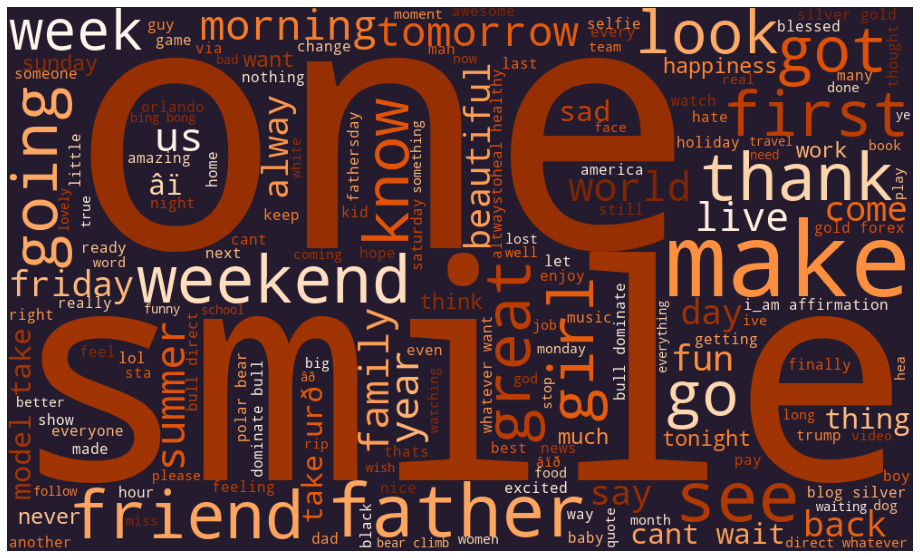

In [80]:
wc = WordCloud(width = 1000, height = 600, background_color = "#241b2f", min_font_size = 12, colormap = 'Oranges')

wc.generate(vis)

plt.figure(figsize=(20,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [81]:
# feature extraction
test_X = test['clean_tweet'] 

### **Prediction using Machine Learning(TF_IDF)**

In [82]:
# TF_IDF
test_f = fe.transform(test_X)
test_f = test_f.toarray()
test_f

# Prediction
test1_pred = rfc2.predict(test_f) 

# to array
test1_pred.tolist()
test1_pred

test_X = test_X.to_numpy()

In [83]:
# Making a dictionary
data = {'tweet' : test_X, 'predictions' : test1_pred}

# Making a new Data Frame of predictions
df_pred = pd.DataFrame.from_dict(data)

# One Hot Encoding
df_pred.loc[df_pred['predictions'] == 0, 'predictions'] = 'Not Offensive'
df_pred.loc[df_pred['predictions'] == 1, 'predictions'] = 'Offensive'

# Predictions Counts
df_pred['predictions'].value_counts()

Not Offensive    15961
Offensive         1236
Name: predictions, dtype: int64

In [84]:
# To Download the DataSet run this code

# df_pred.to_csv('predictions_ML.csv')

### **Bidirectional LSTM and Multi-layer**

In [85]:
# All the procedure on New Test Data

test_X_sequence = tokenizer.texts_to_sequences(test_X)
test_X_matrix = sequence.pad_sequences(test_X_sequence, max_length)
test_X_matrix

array([[    0,     0,     0, ...,  2100, 13770,   126],
       [    0,     0,     0, ...,    11,   508, 11549],
       [    0,     0,     0, ...,   168,    43,   227],
       ...,
       [    0,     0,     0, ...,    34,  1500,   106],
       [    0,     0,     0, ...,   871,    27,   391],
       [    0,     0,     0, ...,  2219,  5911, 12400]], dtype=int32)

In [86]:
# Prediction using ANN
ann_pred = model2.predict(test_X_matrix)
ann_pred = np.where(ann_pred >= 0.5, 1, 0)

In [87]:
# to 1D array
ann_pred = ann_pred.flatten()
ann_pred

# Making a dictionary
data = {'tweet' : test_X, 'predictions' : ann_pred}

In [88]:
# Making a new Data Frame of predictions
df_pred_ann = pd.DataFrame.from_dict(data)

# One Hot Encoding
df_pred_ann.loc[df_pred_ann['predictions'] == 0, 'predictions'] = 'Not Offensive'
df_pred_ann.loc[df_pred_ann['predictions'] == 1, 'predictions'] = 'Offensive'

# Predictions Counts
df_pred_ann['predictions'].value_counts()

Not Offensive    15970
Offensive         1227
Name: predictions, dtype: int64

In [89]:
# To Download the DataSet run this code

# df_pred.to_csv('predictions_ann.csv')